# <a id='toc1_'></a>[Using Stable Diffusion with AWS JumpStart](#toc0_)

This sample notebook shows you how to deploy SDXL from Stability AI as an endpoint on Amazon SageMaker.

> **Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.


## <a id='toc1_1_'></a>[Prerequisites](#toc0_)

1. **Note**: Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.

1. Ensure that IAM role used has **AmazonSageMakerFullAccess**

1. To deploy the ML model successfully using the steps in this notebook, ensure that either:
    1. Your IAM role has the following three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. Or your AWS account has a subscription to [the SDXL Jumpstart](https://aws.amazon.com/marketplace/pp/prodview-3j5jzj4k6slxs). If so, skip step: [Subscribe to the model package](#1.-Subscribe-to-the-model-package) 




## <a id='toc1_2_'></a>[Resources](#toc0_)


1. [Stability SDK documentation](https://api.stability.ai/docs#tag/v1generation)

2. [Documentation on real-time inference with Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).


## <a id='toc1_3_'></a>[Usage instructions](#toc0_)
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).


   
- [1. Subscribe to the SDXL Model Package](#toc3_)    
- [2: Create an endpoint and perform real-time inference](#toc4_)    
  - [A: Text to image](#toc4_1_)    
  - [B: Image to image](#toc4_2_)    
- [3: Delete the endpoint](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc3_'></a>[1. Subscribe to the SDXL Model Package](#toc0_)

To subscribe to the SDXL Model Package:
1. Open the SDXL Model Package listing page: https://aws.amazon.com/marketplace/pp/prodview-3j5jzj4k6slxs
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization accept the EULA, pricing, and support terms.

In [6]:
!pip install 'stability-sdk[sagemaker] @ git+https://github.com/Stability-AI/stability-sdk.git@sagemaker'

import sagemaker
from sagemaker import ModelPackage, get_execution_role
from stability_sdk_sagemaker.predictor import StabilityPredictor
from stability_sdk_sagemaker.models import get_model_package_arn
from stability_sdk.api import GenerationRequest, GenerationResponse, TextPrompt

from PIL import Image
from typing import Union
import io
import os
import base64
import boto3

  Cloning https://github.com/Stability-AI/stability-sdk.git (to revision sagemaker) to /tmp/pip-install-i2np1p8a/stability-sdk_e916d99faafb4eb58509a54ed7a6e2a6
  Running command git clone --filter=blob:none --quiet https://github.com/Stability-AI/stability-sdk.git /tmp/pip-install-i2np1p8a/stability-sdk_e916d99faafb4eb58509a54ed7a6e2a6
  Running command git checkout -b sagemaker --track origin/sagemaker
  Switched to a new branch 'sagemaker'
  Branch 'sagemaker' set up to track remote branch 'sagemaker' from 'origin'.
  Resolved https://github.com/Stability-AI/stability-sdk.git to commit c61601339de678d706d5ba3b1ca182705cdffe61
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


# <a id='toc4_'></a>[2: Create an endpoint and perform real-time inference](#toc0_)

In [8]:

# Choose your endpoint name
endpoint_name='jumpstart-sdxl-stability' # change this for each deployment


Once you have subscribed to Stability SDXL, get the Model Package ARN using the map below:


In [12]:
model_package_map = {
    "us-east-1": "arn:aws:sagemaker:us-east-1:865070037744:model-package/stable-diffusion-xl-beta-v2-2--80252c537a5a396280cdd21b5f8b298e",
    "us-east-2": "arn:aws:sagemaker:us-east-2:057799348421:model-package/stable-diffusion-xl-beta-v2-2--80252c537a5a396280cdd21b5f8b298e",
    "us-west-2": "arn:aws:sagemaker:us-west-2:594846645681:model-package/stable-diffusion-xl-beta-v2-2--80252c537a5a396280cdd21b5f8b298e",
    "ca-central-1": "arn:aws:sagemaker:ca-central-1:470592106596:model-package/stable-diffusion-xl-beta-v2-2--80252c537a5a396280cdd21b5f8b298e",
    "eu-central-1": "arn:aws:sagemaker:eu-central-1:446921602837:model-package/stable-diffusion-xl-beta-v2-2--80252c537a5a396280cdd21b5f8b298e",
    "eu-west-1": "arn:aws:sagemaker:eu-west-1:985815980388:model-package/stable-diffusion-xl-beta-v2-2--80252c537a5a396280cdd21b5f8b298e",
    "eu-west-2": "arn:aws:sagemaker:eu-west-2:856760150666:model-package/stable-diffusion-xl-beta-v2-2--80252c537a5a396280cdd21b5f8b298e",
    "ap-northeast-2": "arn:aws:sagemaker:ap-northeast-2:745090734665:model-package/stable-diffusion-xl-beta-v2-2--80252c537a5a396280cdd21b5f8b298e",
    "ap-northeast-1": "arn:aws:sagemaker:ap-northeast-1:977537786026:model-package/stable-diffusion-xl-beta-v2-2--80252c537a5a396280cdd21b5f8b298e",
    "ap-south-1": "arn:aws:sagemaker:ap-south-1:077584701553:model-package/stable-diffusion-xl-beta-v2-2--80252c537a5a396280cdd21b5f8b298e"
}


region = boto3.Session().region_name
if region not in model_package_map.keys():
    raise ("UNSUPPORTED REGION")
package_arn = model_package_map[region]
role_arn = get_execution_role()
sagemaker_session = sagemaker.Session()

In [13]:
package_arn

'arn:aws:sagemaker:us-east-1:865070037744:model-package/stable-diffusion-xl-beta-v2-2--80252c537a5a396280cdd21b5f8b298e'

Create a deployable `ModelPackage`:

In [21]:
model = ModelPackage(role=role_arn,model_package_arn=package_arn,sagemaker_session=sagemaker_session,predictor_cls=StabilityPredictor)

In [22]:
# Deploy the ModelPackage. This will take 5-10 minutes to run
# Instance type ml.g5.xlarge is sufficient for SDXL
deployed_model = model.deploy(initial_instance_count=1,instance_type='ml.g5.xlarge',endpoint_name=endpoint_name)


-------------!

If you have already deployed your model, you can also access it via your chosen `endpoint_name` and `sagemaker_session`:


In [23]:

deployed_model = StabilityPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)


We can call `predict` on our deployed model to return model outputs. For the full list of parameters, [see the Stability.ai SDK documentation.](https://api.stability.ai/docs#tag/v1generation)

## <a id='toc4_1_'></a>[A: Text to image](#toc0_)


In [53]:
%%time

output = deployed_model.predict(GenerationRequest(text_prompts=[TextPrompt(text="Design a futuristic cityscape with towering skyscrapers reaching towards the sky, adorned with intricate glass facades reflecting the surrounding lights and bustling streets filled with pedestrians and vehicles.")],
                                             style_preset="cinematic",
                                                  width=768,
                                                  height= 512,
                                                  cfg_scale= 7,
                                             seed = 3
                                             ))


CPU times: user 16.8 ms, sys: 339 µs, total: 17.2 ms
Wall time: 3.75 s


In [55]:
#output

Output images are included in the response's `artifacts` as base64 encoded strings. Below is a helper function for accessing decoding these images:

In [72]:
def decode_and_show(model_response: GenerationResponse) -> None:
    """
    Decodes and displays an image from SDXL output

    Args:
        model_response (GenerationResponse): The response object from the deployed SDXL model.

    Returns:
        None
    """
    image = model_response.artifacts[0].base64
    image_data = base64.b64decode(image.encode())
    image = Image.open(io.BytesIO(image_data))
    #display(image)
    return image

#decode_and_show(output)


Let's try passing in a `style_preset`. See the [Stability SDK documentation](https://api.stability.ai/docs#tag/v1generation) for a full list of available presets.

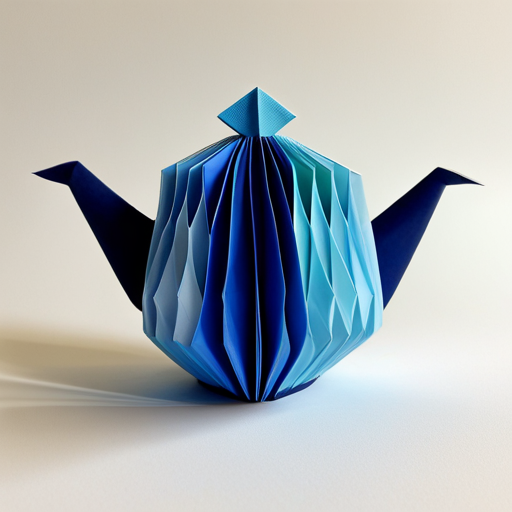

In [69]:
%%time
output = deployed_model.predict(GenerationRequest(text_prompts=[TextPrompt(text="teapot")],
                                             style_preset="origami",
                                             seed = 1234
                                             ))
img = decode_and_show(output)
img.save('origame.png')

SDXL can render short snippets of text, like single words. Let's try a couple of examples below.

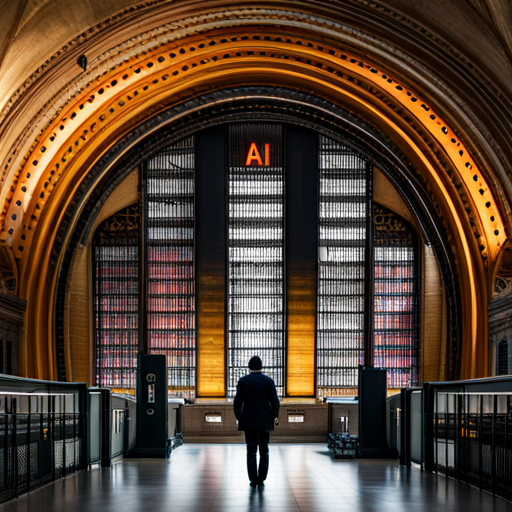

AttributeError: 'NoneType' object has no attribute 'save'

In [67]:
text = "A sign that says AI on a vintage railway departures board in a busy Grand Central Station"
output = deployed_model.predict(GenerationRequest(text_prompts=[TextPrompt(text=text)],
                                             cfg_scale=9,
                                             seed=7,
                                             sampler="DDIM",
                                             ))
generated = decode_and_show(output)
generated.save("img.png")

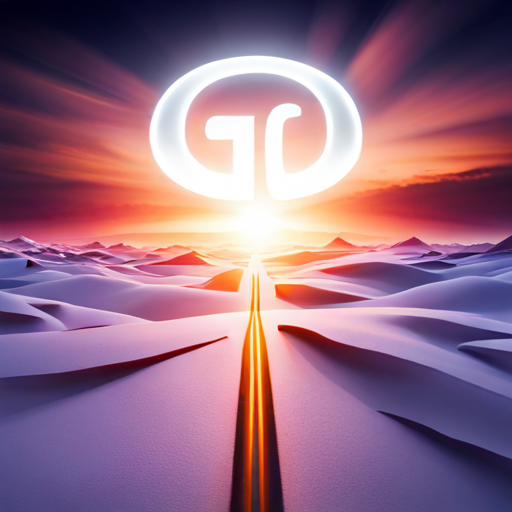

In [59]:
text = "A sign that says go"
output = deployed_model.predict(GenerationRequest(text_prompts=[TextPrompt(text=text)],
                                            cfg_scale=9,
                                             seed=42,
                                             sampler="DDIM",
                                             ))
decode_and_show(output)

## <a id='toc4_2_'></a>[B: Image to image](#toc0_)

To perform inference that takes an image as input, you must pass the image into `init_image` as a base64-encoded string. Images must be of size (512, 512).

Below is a helper function for converting images to base64-encoded strings:

In [60]:
def encode_image(image_path: str, resize: bool = True) -> Union[str, None]:
    """
    Encode an image as a base64 string, optionally resizing it to 512x512.

    Args:
        image_path (str): The path to the image file.
        resize (bool, optional): Whether to resize the image. Defaults to True.

    Returns:
        Union[str, None]: The encoded image as a string, or None if encoding failed.
    """
    assert os.path.exists(image_path)

    if resize:
        image = Image.open(image_path)
        image = image.resize((512, 512))
        image_base = os.path.splitext(image_path)[0]
        image_resized_path = f"{image_base}_resized.png"
        image.save(image_resized_path)
        image_path = image_resized_path
    image = Image.open(image_path)
    assert image.size == (512, 512)
    with open(image_path, "rb") as image_file:
        img_byte_array = image_file.read()
        # Encode the byte array as a Base64 string
        try:
            base64_str = base64.b64encode(img_byte_array).decode("utf-8")
            return base64_str
        except Exception as e:
            print(f"Failed to encode image {image_path} as base64 string.")
            print(e)
            return None
    

Let's feed an image into the model as well as the prompt this time. We can set `image_scale` to weight the relative importance of the image and the prompt. For the demo, we'll use a [picture of the cat, taken from Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Cat_August_2010-4.jpg), provided along with this notebook.

In [61]:
! wget https://platform.stability.ai/Cat_August_2010-4.jpg

--2023-06-05 00:58:47--  https://platform.stability.ai/Cat_August_2010-4.jpg
Resolving platform.stability.ai (platform.stability.ai)... 104.18.20.212, 104.18.21.212, 2606:4700::6812:15d4, ...
Connecting to platform.stability.ai (platform.stability.ai)|104.18.20.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28624 (28K) [image/jpeg]
Saving to: ‘Cat_August_2010-4.jpg’

Cat_August_2010-4.j 100%[===================>]  27.95K  --.-KB/s    in 0s      

2023-06-05 00:58:48 (85.1 MB/s) - ‘Cat_August_2010-4.jpg’ saved [28624/28624]



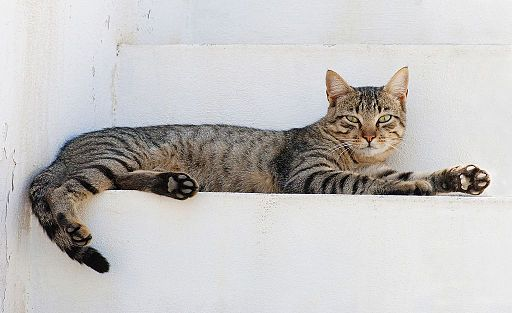

In [62]:
# Here is the original image:
display(Image.open('Cat_August_2010-4.jpg'))

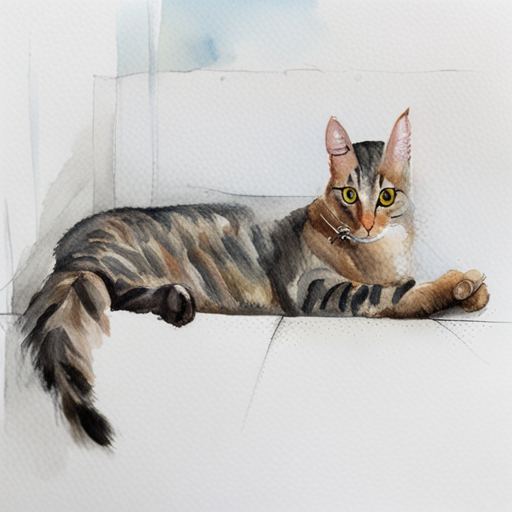

In [63]:
cat_path = "Cat_August_2010-4.jpg"
cat_data = encode_image(cat_path)

output = deployed_model.predict(GenerationRequest(text_prompts=[TextPrompt(text="cat in watercolour")],
                                                  init_image= cat_data,
                                                  cfg_scale=9,
                                                  image_strength=0.8,
                                                  seed=42
                                                  ))
decode_and_show(output)

This time we'll pass in a new prompt and weight towards the prompt more heavily than the image.

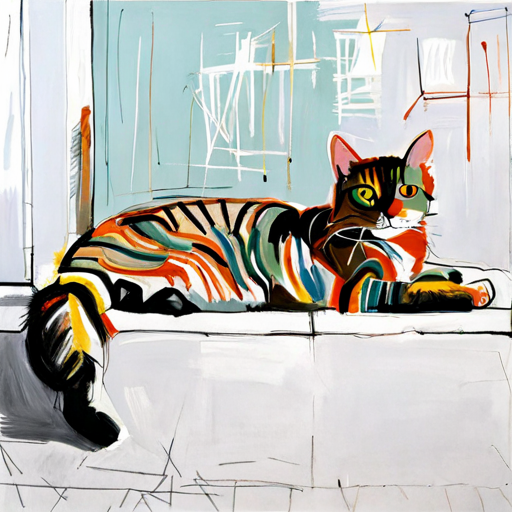

In [64]:
output = deployed_model.predict(GenerationRequest(text_prompts=[TextPrompt(text="cat painted by Basquiat")],
                                                  init_image= cat_data,
                                            cfg_scale=17,
                                            image_strength=0.4,
                                             seed=42
                                             ))
decode_and_show(output)

# <a id='toc5_'></a>[3: Delete the endpoint](#toc0_)

When you've finished working, you can delete the endpoint to release the EC2 instance(s) associated with it, and stop billing.

Get your list of Sagemaker endpoints using the AWS Sagemaker CLI like this:

In [ ]:
!aws sagemaker list-endpoints

In [ ]:
# Delete an endpoint
deployed_model.sagemaker_session.delete_endpoint(endpoint_name)

# Rerun the aws cli command above to confirm that its gone.

# Pruebas

In [86]:
%%time

text = "Produce a portrait of an iconic historical figure with attention to detail, capturing their distinctive features, expressions, and the fashion of their era"

output = deployed_model.predict(GenerationRequest(text_prompts=[TextPrompt(text=text)],
                                             style_preset="cinematic",
                                                  width=512,
                                                  height= 512,
                                                  cfg_scale= 7,
                                                 seed = 3
                                                 ))

img = decode_and_show(output)
img.save('iconic_historical_512x512.png')

CPU times: user 153 ms, sys: 2.84 ms, total: 156 ms
Wall time: 2.9 s


In [87]:
%%time

text = "Produce a portrait of an iconic historical figure with attention to detail, capturing their distinctive features, expressions, and the fashion of their era"

output = deployed_model.predict(GenerationRequest(text_prompts=[TextPrompt(text=text)],
                                             style_preset="cinematic",
                                                  width=768,
                                                  height= 512,
                                                  cfg_scale= 7,
                                                 seed = 3
                                                 ))

img = decode_and_show(output)
img.save('iconic_historical_768x512.png')

CPU times: user 196 ms, sys: 6.93 ms, total: 203 ms
Wall time: 3.95 s


In [89]:
%%time

text = "Produce a portrait of an iconic historical figure with attention to detail, capturing their distinctive features, expressions, and the fashion of their era"

output = deployed_model.predict(GenerationRequest(text_prompts=[TextPrompt(text=text)],
                                             style_preset="cinematic",
                                                  width=896,
                                                  height= 512,
                                                  cfg_scale= 7,
                                                 seed = 3
                                                 ))
img = decode_and_show(output)
img.save('iconic_historical_896x512.png')

CPU times: user 257 ms, sys: 15.1 ms, total: 272 ms
Wall time: 5.18 s
